# Assignment 2 - Approximate Inference
## Probabilistic Models UE
### WS 2017

---
<div class="alert alert-warning">
**Due:** 7.11.2017, 11:00
</div>

<div class="alert alert-info">
**NumPy Hints:**

<ul>
<li>`arr.cumsum()` computes the cumulative sum of an array.</li>
<li>You can index arrays using boolean masks, e.g. `arr[arr > 0.5]`. Here, `arr > 0.5` returns a boolean array that is `True` on each position where the value of `arr` is larger than `0.5`.</li>
<li>You can logically combine binary masks in NumPy using the following operators: `&` for 'and', `|` for 'or', `~` for 'not', etc... Do **not** use Python keywords!</li>
</ul>
</div>

---

Consider the following Bayesian Network (all variables are binary):

<img width='30%' src='bn_2017.svg'>

The conditional probability tables are given as:

<table><tr><th>P(A)</th><th>$a_0$<br></th><th>$a_1$</th></tr><tr><td>-</td><td>0.99</td><td>0.01</td></tr></table>

<table><tr><th>P(B)</th><th>$b_0$<br></th><th>$b_1$</th></tr><tr><td>-</td><td>0.9</td><td>0.1</td></tr></table>

<table><tr><th>P(C | B)</th><th>$b_0$<br></th><th>$b_1$</th></tr><tr><td>$c_0$</td><td>0.8</td><td>0.1</td></tr><tr><td>$c_1$</td><td>0.2</td><td>0.9</td></tr></table>

<table><tr><th rowspan="2">P(D | C, A)</th><th colspan="2">$c_0$<br></th><th colspan="2">$c_1$</th></tr><tr><td>$a_0$</td><td>$a_1$</td><td>$a_0$</td><td>$a_1$</td></tr><tr><td>$d_0$<br></td><td>0.01</td><td>0.7</td><td>0.8</td><td>0.999</td></tr><tr><td>$d_1$</td><td>0.99</td><td>0.3</td><td>0.2</td><td>0.001</td></tr></table>

<table><tr><th>P(E | C)</th><th>$c_0$</th><th>$c_1$</th></tr><tr><td>$e_0$</td><td>0.8</td><td>0.1</td></tr><tr><td>$e_1$</td><td>0.2</td><td>0.9</td></tr></table>

First, store these tables as global NumPy arrays:

In [127]:
from __future__ import print_function
from __future__ import division

%pylab inline
p_A = np.array([0.99 ,0.01])
p_B = np.array([0.9 ,0.1])
p_C_given_B = np.array([#c0  c1
                        [0.8,0.2], #b0
                        [0.1,0.9]  #b1
                       ])
p_D_given_C_and_A = np.array([ #a0           #a1
                              [[0.01,0.99], [0.7,0.3]],   #c0
                              [[0.8,0.2], [0.999,0.001]]  #c1
                             ])
p_E_given_C =np.array([
                        [0.8,0.2], #c0
                        [0.1,0.9]  #c1
                       ])




Populating the interactive namespace from numpy and matplotlib


/home/yaser/anaconda2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['e']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


---

# 1. Approximate Inference

Implement functions that use different strategies to compute $P(B \mid D, E)$. Use the function stubs given in the code cells below. The functions take the values for $D$ and $E$ as parameters. You can add additional helper functions if necessary.

Implement a function that approximates $P(B \mid D, E)$ using ...

### 1.1 Rejection Sampling. (5 points)

In Rejection Sampling, one samples from the joint probability distribution, and throws away ('rejects') all samples that do not correspond to the evidence. We will split this functionality in two functions:

In [128]:
def rejection_sampling(d, e, n=1000):
    samples = np.empty((n,5))#A,B,C,D,E x 1000 sample
    for i in range(0,n):
        #A
        rand = random.uniform(0, 1)
        samples[i][0] = 0
        
        if rand>p_A[0]:
            samples[i][0] = 1
        
        
        #B
        rand = random.uniform(0, 1)
        samples[i][1] = 0
        
        if rand>p_B[0]:
            samples[i][1] = 1
        
        #C
        rand = random.uniform(0, 1)
        samples[i][2] = 0
        if rand>p_C_given_B[int(samples[i][1])][0]:
            samples[i][2] = 1
        
        
        #D
        rand = random.uniform(0, 1)
        samples[i][3] = 0
        if rand > p_D_given_C_and_A[int(samples[i][2])][int(samples[i][0])][0]:
            samples[i][3] = 1
        
        
        #E
        rand = random.uniform(0, 1)
        samples[i][4] = 0
        
        if rand>p_E_given_C[int(samples[i][2])][0]:
            samples[i][4] = 1
        
        
    evidence_counter = 0
    query_counter = 0
    for i in range(0,n):
        if samples[i][3] == d and samples[i][4] == e:
            evidence_counter= evidence_counter+1
            if samples[i][1] == 1:
                query_counter = query_counter+1

    
    if evidence_counter == 0:
        prob_B_D_and_E = np.array([1, 0])
    else:
        prob_B_D_and_E = np.array([1-query_counter/evidence_counter, #b0
                               query_counter/evidence_counter]) #b1
    
    
            
    return prob_B_D_and_E
print(rejection_sampling(0, 0, 1000))

[ 0.725  0.275]


### 1.2 Likelihood Weighting. (5 points)

In likelihood weighting, we do not throw away samples. Instead, we force the samples to have the correct evidence, but *weight* them according to the *likelihood* of the evidence. Since we will need the sampling function as a seed for Gibbs sampling, we create a seperate function for it.

In [129]:

#A,B,C,D,E,weight x 1000 sample
def likelihood_weighting(d, e, n=1000):
    samples_lw = np.empty((n,6))   
    for i in range(0,n):
        samples_lw[i][5] = 1
        #A
        rand = random.uniform(0, 1)

        samples_lw[i][0] = 0
        
        if rand>p_A[0]:
            samples_lw[i][0] = 1
        
        
        #B
        rand = random.uniform(0, 1)
        samples_lw[i][1] = 0
        
        if rand>p_B[0]:
            samples_lw[i][1] = 1
        
        #C
        rand = random.uniform(0, 1)
        samples_lw[i][2] = 0
        if rand>p_C_given_B[int(samples_lw[i][1])][0]:
            samples_lw[i][2] = 1
        
        
        #D
        
        if d == 1:
            samples_lw[i][3] = 1
            samples_lw[i][5]*=p_D_given_C_and_A[int(samples_lw[i][2])][int(samples_lw[i][0])][1]
        else:
            samples_lw[i][3] = 0
            samples_lw[i][5]*=p_D_given_C_and_A[int(samples_lw[i][2])][int(samples_lw[i][0])][0]
        
        #E
        
        if e == 1:
            samples_lw[i][4] = 1
            samples_lw[i][5]*=p_E_given_C[int(samples_lw[i][2])][1]
        else:
            samples_lw[i][4] = 0
            samples_lw[i][5]*=p_E_given_C[int(samples_lw[i][2])][0]
    
    
  
    query_weights = 0
    for i in range(0,n):
        if samples_lw[i][1] == 1:
            query_weights += samples_lw[i][5] 
            #b0                                         #b1
    return (1 - query_weights/sum(samples_lw[:,5]) , query_weights/sum(samples_lw[:,5]) )
    
     
        
    """ 
    Approximates P(B | D=d, E=e) using likelihood weighting
    :param d: given value for D
    :param e: given value for E
    :param n: number of samples to use
    :returns: Numpy array containing the approximated distribution
    """
likelihood_weighting(0, 0, n=1000)

(0.79326179474124092, 0.20673820525875908)

### 1.3 Gibbs Sampling. (7 points)

You can pre-compute the necessary resampling distributions and store them as global variables, just as the CPTs.

I didnt know whether or not its required to perfrom the gibbs function with the burn in samples and the sample distance, so I wrote the code required -in comments- in the next cell: 

In [130]:
       
#        #burn in
#        if n_burn_in_samples == i and burn_in_flag == 0:
#            samples_gibbs[1,:] = samples_gibbs[0,:]
#            burn_in_flag = 1
#            sample_flag = 1
#            stop_burn = 1
#            print("shit")
#            print (i)
#        elif stop_burn == 0:
#            i = 0
#            n_burn_in_samples = n_burn_in_samples - 1
            
            
#        #sample distance
#        if  sample_distance_counter == 1 and sample_flag == 1:
#            samples_gibbs[i,:] = samples_gibbs[i-1,:]
#            sample_distance_counter = sample_distance
#        else:
#           i = i - 1
#            sample_distance_counter = sample_distance_counter - 1
    

In [131]:
def gibbs_sampling(d, e, n_burn_in_samples=0, sample_distance=1, n=1000):
    samples_gibbs = np.empty((n,5))
    #choosse a random
    samples_gibbs[0,:] = [0 , 1,1,d,e]
    sample_flag = 0
    burn_in_flag = 0
    stop_burn = 0
    sample_distance_counter = 1
    
    for i in range(1,n):

        samples_gibbs[i,:] = samples_gibbs[i-1,:] 
        
        #print (i)   
        #choose A
        num = p_A[int(samples_gibbs[i,0])]*p_D_given_C_and_A[int(samples_gibbs[i,2])][int(samples_gibbs[i,0])][int(samples_gibbs[i,3])]
        den = num + p_A[int(1-samples_gibbs[i,0])]*p_D_given_C_and_A[int(samples_gibbs[i,2])][int(1-samples_gibbs[i,0])][int(samples_gibbs[i,3])]                   
        pA_given_all = num/den
        rand = random.uniform(0, 1)
        if rand > pA_given_all:
            samples_gibbs[i,0] = 1 - samples_gibbs[i,0]
                  
        
        #choose B
        num = p_B[int(samples_gibbs[i,1])]*p_C_given_B[int(samples_gibbs[i,1])][int(samples_gibbs[i,2])]
        den = num + p_B[int(1-samples_gibbs[i,1])]*p_C_given_B[int(1-samples_gibbs[i,1])][int(samples_gibbs[i,2])]
        pB_given_all = num/den
        rand = random.uniform(0, 1)
        if rand > pB_given_all:
            samples_gibbs[i,1] = 1 - samples_gibbs[i,1]
    
        #choose C
        num = p_C_given_B[int(samples_gibbs[i,1])][int(samples_gibbs[i,2])]*p_D_given_C_and_A[int(samples_gibbs[i,2])][int(samples_gibbs[i,0])][int(samples_gibbs[i,3])]*p_E_given_C[int(samples_gibbs[i,2])][int(samples_gibbs[i,4])]
        den = num + p_C_given_B[int(samples_gibbs[i,1])][int(1-samples_gibbs[i,2])]*p_D_given_C_and_A[int(1-samples_gibbs[i,2])][int(samples_gibbs[i,0])][int(samples_gibbs[i,3])]*p_E_given_C[int(1-samples_gibbs[i,2])][int(samples_gibbs[i,4])]
        pC_given_all = num/den
        rand = random.uniform(0, 1)
        if rand > pC_given_all:
            samples_gibbs[i,2] = 1 - samples_gibbs[i,2]
    
    
    query_counter_positive = 0
    for i in range(0,n):
        if samples_gibbs[i,1] == 1:
            query_counter_positive= query_counter_positive+1
            
    query_counter_positive/n
           #b0                                #b1
    return (1 - (query_counter_positive/n),query_counter_positive/n)
gibbs_sampling(1,1)

(0.9319999999999999, 0.068)

---

# 2. Comparison

In this exercise, you will compare the accuracy of approximation to the exact solution. To this end, 

### 2.1 implement a function that computes $P(B \mid D, E)$ exactly. (3 points)

We will solve this in a very inefficient manner - by first computing the joint probability distribution, and then $P(B \mid D, E)$.

In [132]:
def exact(d, e):
                                    #b  #c                   #c #a #d               #c #e
    p_1_1 = p_A[0]*p_B[0]*p_C_given_B[0][0]*p_D_given_C_and_A[0] [0] [d]*p_E_given_C[0] [e]
    p_1_2 = p_A[1]*p_B[0]*p_C_given_B[0][0]*p_D_given_C_and_A[0] [1] [d]*p_E_given_C[0] [e]
    p_1_3 = p_A[0]*p_B[0]*p_C_given_B[0][1]*p_D_given_C_and_A[1] [0] [d]*p_E_given_C[1] [e]
    p_1_4 = p_A[1]*p_B[0]*p_C_given_B[0][1]*p_D_given_C_and_A[1] [1] [d]*p_E_given_C[1] [e]
    p_1 = p_1_1+p_1_2+p_1_3+p_1_4
    p_2_1 = p_A[0]*p_B[1]*p_C_given_B[1][0]*p_D_given_C_and_A[0] [0] [d]*p_E_given_C[0] [e]
    p_2_2 = p_A[1]*p_B[1]*p_C_given_B[1][0]*p_D_given_C_and_A[0] [1] [d]*p_E_given_C[0] [e]
    p_2_3 = p_A[0]*p_B[1]*p_C_given_B[1][1]*p_D_given_C_and_A[1] [0] [d]*p_E_given_C[1] [e]
    p_2_4 = p_A[1]*p_B[1]*p_C_given_B[1][1]*p_D_given_C_and_A[1] [1] [d]*p_E_given_C[1] [e]
    p_2 = p_2_1+p_2_2+p_2_3+p_2_4
    
    
    """ 
    Computes P(B | D, E) using exact inference
    :param d: given value for D
    :param e: given value for E
    :returns: Numpy array containing the distribution
    """
            #bo               #b1
    return ((p_1/(p_1+p_2)),(1-(p_1/(p_1+p_2))))

exact(0,1)
            

(0.67066293112215258, 0.32933706887784742)

Then,

### 2.2 plot and interpret the estimation errors depending on the number of samples used. (3 points)

To do this, just run the code cells below. When the approximations are ready, the plots should appear. Mind the scale of the axes: both are logarithmic!

**Interpret the results in detail:** Why does convergence speed differ for different values of $D$ and $E$? How do the approximation methods compare and why? Did anything surprise you? Why, or why not?

*Note that the points are given for the interpretation, not the plotting itself.*

In [133]:
def kld(p, q):
    """
    Computes the Kullback-Leibler divergence between p and q.
    :param p: true distribution
    :param q: estimated distribution
    :return: Kullback-Leibler Divergence between p and q
    """
    return (p * np.log(p / (q + 1e-10))).sum()  # add a small constant for numeric stability


def approx_error(approx_function, d, e, n_runs, sample_counts, **kwargs):
    """
    Computes the approximation error for a given approximation method.
    :param approx_function: function used to approximate the distribution
    :param d: given value for D
    :param e: given value for E
    :param n_runs: number of approximations
    :param sample_counts: list or array of numbers of sampels to use
    :returns: mean approximation error for each of the sample counts
    """
    mean_errors = []
    correct = exact(d, e)
    
    for num_samples in sample_counts:
        estimates = array([approx_function(d, e, n=num_samples, **kwargs) for i in range(n_runs)])
        mean_errors.append(kld(correct, estimates) / len(estimates))
    
    return mean_errors

rs_errs = {}
lw_errs = {}
gb_errs = {}
n_runs = 100
sample_counts = array([10, 20, 40, 80, 160, 320, 640, 1280])

for d, e in zip([0, 0, 1, 1], [0, 1, 0, 1]):
    rs_errs[(d, e)] = approx_error(rejection_sampling, d, e, n_runs, sample_counts)
    lw_errs[(d, e)] = approx_error(likelihood_weighting, d, e, n_runs, sample_counts)
    gb_errs[(d, e)] = approx_error(gibbs_sampling, d, e, n_runs, sample_counts)



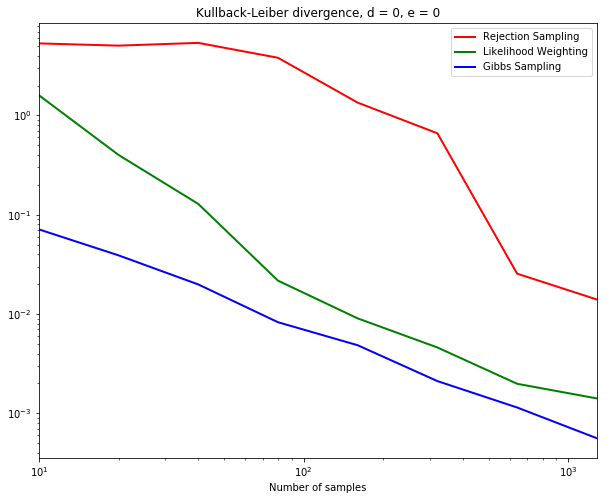

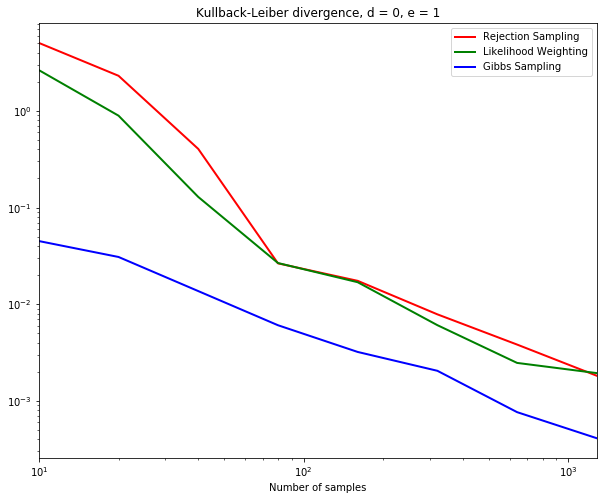

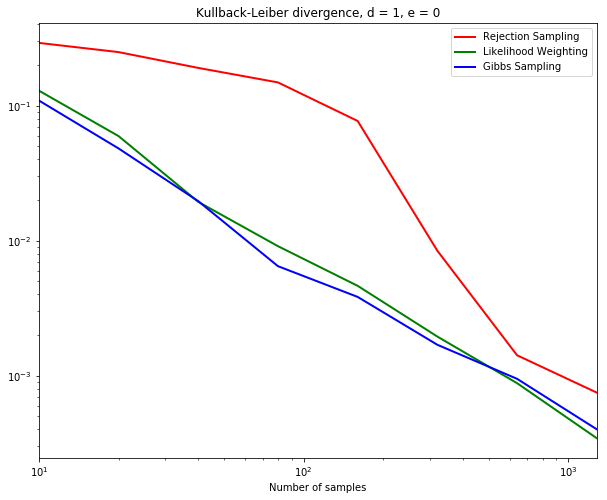

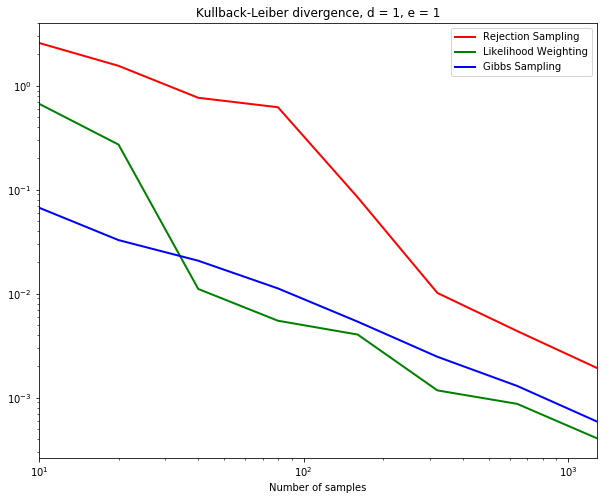

In [134]:
for d, e in zip([0, 0, 1, 1], [0, 1, 0, 1]):
    figure(figsize=(10, 8))
    title('Kullback-Leiber divergence, d = %d, e = %d' % (d, e))

    plot(sample_counts, rs_errs[(d, e)], 'r', label='Rejection Sampling', lw=2)
    plot(sample_counts, lw_errs[(d, e)], 'g', label='Likelihood Weighting', lw=2)
    plot(sample_counts, gb_errs[(d, e)], 'b', label='Gibbs Sampling', lw=2)   
    
    legend()
    xscale('log')
    yscale('log')
    xlim(sample_counts.min(), sample_counts.max())
    xlabel('Number of samples')

question 1: because different probabilities are assigned to different values of d and e.
so for (d,e) that are more probable, they would appear more using the RS method-hence converge faster-.

for (d,e) that are more probable, for the LW, the weights that would be multiplied to the samples would be 
according to how probably the values(d,e) are. Therefore, for high probable(d,e), high weights would be multiplied
and therefore converging faster as samples that are generated are less likely to be useless

for gibbs sampling, we include p(evidence|cause) as a way of feedback to check whether an event is overly estimated
or under estimated. so the convergance rate is also going to be proportional to whether to the likelihood of a 
given (d,e)


question 2 The rejection sampling has the slowest convergence due to the fact that it generates samples that aren't used
at the end. The amount of the samples used in the end are as probable as the atomic events that is been investigated.

for the LW sampling, it converges a bit faster and the reason is that all the samples generated are used
but it also slow comparing it to the gibbs sampling as it generates samples that are highly improbable and then 
corrects the result using a weight

for the gibbs sampling, its the fastest as it takes into account all the values of the evidences and checks how 
probable/improbable they are. and therefore, every next sample is closer to the target distribution

question 3:
Yes, the strange thing is that the for (d,e) = (1,1), the LW had a faster convergence rate than the gibbs sampling.
Explanation: the weigths associated with (d,e) = (1,1) are highly probable and therefore likelihood converged faster.